In [1]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import os

from google.colab import drive
from skimage.io import imread
from skimage.transform import resize
import sys
from IPython.display import clear_output
import gc

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torchvision.transforms as transforms

from matplotlib import rcParams

from time import time
import copy
from dataclasses import dataclass, asdict
import pickle

import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import random

from collections import Counter
from sklearn.metrics import classification_report

In [2]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

os.chdir(f'./Transformer-Explainability')

!pip install einops

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 386 (delta 3), reused 2 (delta 2), pack-reused 381 (from 2)
Receiving objects: 100% (386/386), 3.85 MiB | 15.52 MiB/s, done.
Resolving deltas: 100% (194/194), done.


# Load data

In [3]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2025-06-09 14:10:06--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70 [following]
--2025-06-09 14:10:06--  https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4b8a4d69c75b8376a0676afa90.dl.dropboxusercontent.com/cd/0/inline/CrQKAuUJRB5SmhWhnp0XaM6oGIxKF_jk7ru1snZzX1H3a2YNVfbGf65EMHh53TftbKGhGDZMcXi4i9GqztX8-o7GwZZvTae10-Lc1H696by-dt1gCPDeOGzEBADjVIikLpY/file# [following]
--2025-06-09 14:10:07--  https://uc4b8a4d69c75b8376a0676afa90.dl.dropboxusercontent.com/cd/0/inline/CrQKAuUJRB5SmhWh

In [4]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [5]:
rcParams['figure.figsize'] = (15,4)

# drive.mount('/content/drive', force_remount=True)
drive_path = "/content/Transformer-Explainability/PH2Dataset"
# drive_path = "Transformer-Explainability/PH2Dataset"

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


Processing Directories: 100%|██████████| 627/627 [00:00<00:00, 678.35it/s] 


Cleaned 200 images, 200 masks, and 200 labels.


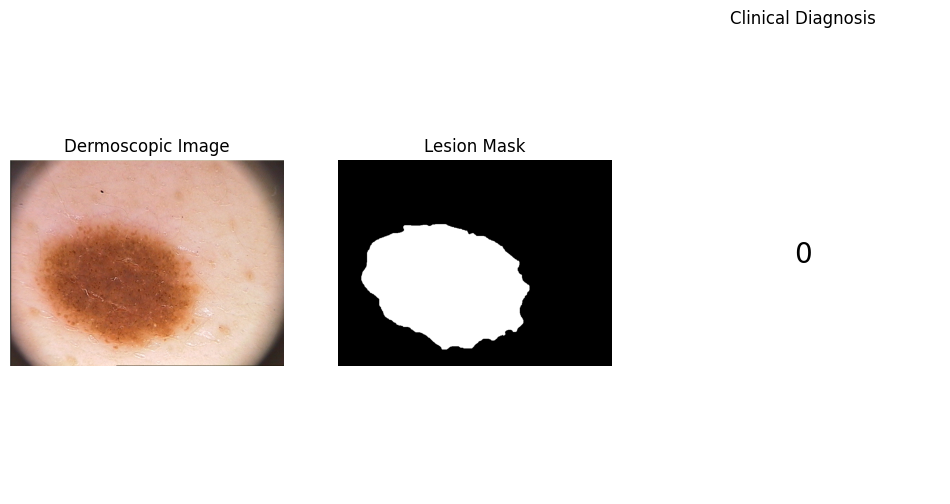

In [6]:
root_path = "/kaggle/working/Transformer-Explainability/PH2Dataset/PH2 Dataset images"
metadata_path = "/kaggle/working/Transformer-Explainability/PH2Dataset/PH2_dataset.txt"
# Load metadata
metadata = pd.read_csv(metadata_path, sep="\\|", engine="python", skipinitialspace=True)
metadata.columns = metadata.columns.str.strip()  # Clean column names
metadata = metadata.dropna(how="all", axis=1)  # Drop empty columns
metadata = metadata[["Name", "Clinical Diagnosis"]]
metadata["Name"] = metadata["Name"].str.strip()  # Clean image names
metadata["Clinical Diagnosis"] = pd.to_numeric(metadata["Clinical Diagnosis"], errors="coerce")

# Remove rows with NaN in Clinical Diagnosis
metadata = metadata.dropna(subset=["Clinical Diagnosis"])
metadata["Clinical Diagnosis"] = metadata["Clinical Diagnosis"].astype(int)

# Initialize data storage
images = []
lesions = []
image_names = []

# Gather all directories in the root path
all_dirs = [os.path.join(root, d) for root, dirs, _ in os.walk(root_path) for d in dirs]

# Process directories
for directory in tqdm(all_dirs, desc="Processing Directories"):
    if directory.endswith('_Dermoscopic_Image'):
        # Load the first image file in the directory
        image_files = os.listdir(directory)
        if image_files:  # Ensure the directory is not empty
            image_name = os.path.basename(directory).replace('_Dermoscopic_Image', '')
            image_names.append(image_name)
            images.append(imread(os.path.join(directory, image_files[0])))
    if directory.endswith('_lesion'):
        # Load the first lesion file in the directory
        lesion_files = os.listdir(directory)
        if lesion_files:  # Ensure the directory is not empty
            lesions.append(imread(os.path.join(directory, lesion_files[0])))

# Match images, masks, and clinical diagnoses
matched_labels = []
matched_images = []
matched_lesions = []

for i, name in enumerate(image_names):
    label_row = metadata[metadata["Name"] == name]
    if not label_row.empty:
        matched_labels.append(label_row["Clinical Diagnosis"].values[0])
        matched_images.append(images[i] if i < len(images) else None)
        matched_lesions.append(lesions[i] if i < len(lesions) else None)

# Data Cleaning: Remove any unmatched or None entries
cleaned_images = []
cleaned_lesions = []
cleaned_labels = []

for img, lesion, label in zip(matched_images, matched_lesions, matched_labels):
    if img is not None and lesion is not None and not np.isnan(label):
        cleaned_images.append(img)
        cleaned_lesions.append(lesion)
        cleaned_labels.append(label)

# Check the cleaned data
print(f"Cleaned {len(cleaned_images)} images, {len(cleaned_lesions)} masks, and {len(cleaned_labels)} labels.")

# Plot a single sample
if cleaned_images and cleaned_lesions and cleaned_labels:
    sample_index = 0  # Choose the first sample for plotting

    plt.figure(figsize=(12, 6))

    # Display the image
    plt.subplot(1, 3, 1)
    plt.imshow(cleaned_images[sample_index], cmap='gray')
    plt.title("Dermoscopic Image")
    plt.axis('off')

    # Display the mask
    plt.subplot(1, 3, 2)
    plt.imshow(cleaned_lesions[sample_index], cmap='gray')
    plt.title("Lesion Mask")
    plt.axis('off')

    # Display the label
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, str(cleaned_labels[sample_index]), fontsize=20, ha='center')
    plt.title("Clinical Diagnosis")
    plt.axis('off')

    plt.show()
else:
    print("No valid samples to display.")

In [8]:
from torchvision import transforms

class PH2Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

X_train = images
X_temp = images
y_train = cleaned_labels
y_temp = cleaned_labels

# Define data augmentation transformations for training
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define validation/test transformations (no augmentations, only resizing and normalization)
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets
train_dataset = PH2Dataset(X_train, y_train, transform=train_transform)
val_dataset = PH2Dataset(X_temp, y_temp, transform=val_test_transform)
test_dataset = val_dataset
# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Function to count samples in each class
def count_class_samples(dataset):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    return class_counts

# Count samples in train and validation datasets
train_class_counts = count_class_samples(train_dataset)
val_class_counts = count_class_samples(val_dataset)

# Train Model

In [11]:
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_LRP_new
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from torchvision import transforms

# Define class weights for imbalanced dataset
total_samples = sum(train_class_counts.values())
class_weights = [total_samples / train_class_counts[c] for c in range(3)]
class_weights = torch.tensor(class_weights).cuda()

# Weighted sampler for balanced sampling
sample_weights = [1 / train_class_counts[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Update DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model setup
model_A = vit_LRP_new(pretrained=True, num_classes=3).cuda()  # 3 classes: nevus, atypical nevus, melanoma
criterion_A = nn.CrossEntropyLoss(weight=class_weights)
optimizer_A = optim.AdamW(model_A.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_A = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_A, T_0=10, T_mult=2)

model_B = vit_LRP(pretrained=True, num_classes=3).cuda()  # 3 classes: nevus, atypical nevus, melanoma
criterion_B = nn.CrossEntropyLoss(weight=class_weights)
optimizer_B = optim.AdamW(model_B.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_B = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_B, T_0=10, T_mult=2)


def train_model(model, criterion, optimizer, scheduler):
  # Early stopping parameters
  best_accuracy = 0
  patience = 7
  early_stop_count = 0

  num_epochs = 25
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for images, labels in train_loader:
          images = images.cuda()
          labels = labels.long().cuda()


          outputs = model(images)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

      # Validation
      model.eval()
      correct, total = 0, 0
      y_true, y_pred = [], []
      for images, labels in val_loader:
          images = images.cuda()
          labels = labels.long().cuda()

          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())

      accuracy = 100 * correct / total
      print(f"Validation Accuracy: {accuracy:.2f}%")

      # Classification report
      if epoch == num_epochs - 1 or accuracy > best_accuracy:
          print("Classification Report:")
          print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2"]))

      # Early stopping
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          early_stop_count = 0
          torch.save(model.state_dict(), "best_model.pth")  # Save the best model
      else:
          early_stop_count += 1
          if early_stop_count >= patience:
              print("Early stopping triggered.")
              break

      scheduler.step()
  return model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


If you want to train the model, run this.

In [ ]:
model_B = train_model(model_B, criterion_B, optimizer_B, scheduler_B)
torch.save(model_B.state_dict(), "best_model.pth")
state_dict = torch.load("best_model.pth")
model_A.load_state_dict(state_dict)

If you want to load the existing weights, run this.

In [12]:
state_dict = torch.load('/kaggle/input/vit-ph2-weights/best_model_85.pth')
model_A.load_state_dict(state_dict)
model_B.load_state_dict(state_dict)

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),      
    transforms.Normalize(mean=[0.5], std=[0.5])
])

<ipython-input-12-fe079d234a9e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/input/vit-ph2-weights/best_model_85.pth')


In [12]:
def test_model_sample_by_sample(model, test_images, test_labels):
    model.eval()

    correct, total = 0, 0
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),       
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    for idx in range(len(test_images)):
        image = test_images[idx]
        label = test_labels[idx]

        # Ensure `image` is a NumPy array (if not already)
        if not isinstance(image, np.ndarray):
            raise TypeError(f"Expected image to be a numpy array, but got {type(image)}.")

        # Convert to PIL Image and apply transformations
        image = Image.fromarray(image).convert('RGB')  # Ensure RGB mode
        image = val_test_transform(image)  # Apply transformations
        image = image.cuda()  # Move to GPU
        label = torch.tensor(label).long().cuda()  # Ensure label is a LongTensor

        # Enable gradient computation
        image.requires_grad_()

        # Get model output
        outputs = model(image.unsqueeze(0))  # Add batch dimension during inference

        # Compute loss
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(outputs, label.unsqueeze(0))  # Add batch dimension to label

        loss.backward()

        # Get prediction
        _, predicted = torch.max(outputs, 1)

        # Update counters
        total += 1
        correct += (predicted.item() == label.item())
        gradients = image.grad

    # Calculate accuracy
    test_accuracy = 100 * correct / total
    print(f"Total Correct: {correct}")
    print(f"Total Samples: {total}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

In [13]:
test_model_sample_by_sample(model_B, cleaned_images, cleaned_labels)

Total Correct: 170
Total Samples: 200
Test Accuracy: 85.00%


In [13]:
use_thresholding = True
CLS2IDX = {0: 'nevus',
 1: 'atypical nevus',
 2: 'melanoma'}

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


from baselines.ViT.ViT_explanation_generator import LRP
from baselines.ViT.ViT_explanation_generator import Baselines
from torchvision import transforms

b = Baselines(model_A)
attribution_generator = LRP(model_B)

# 1 way

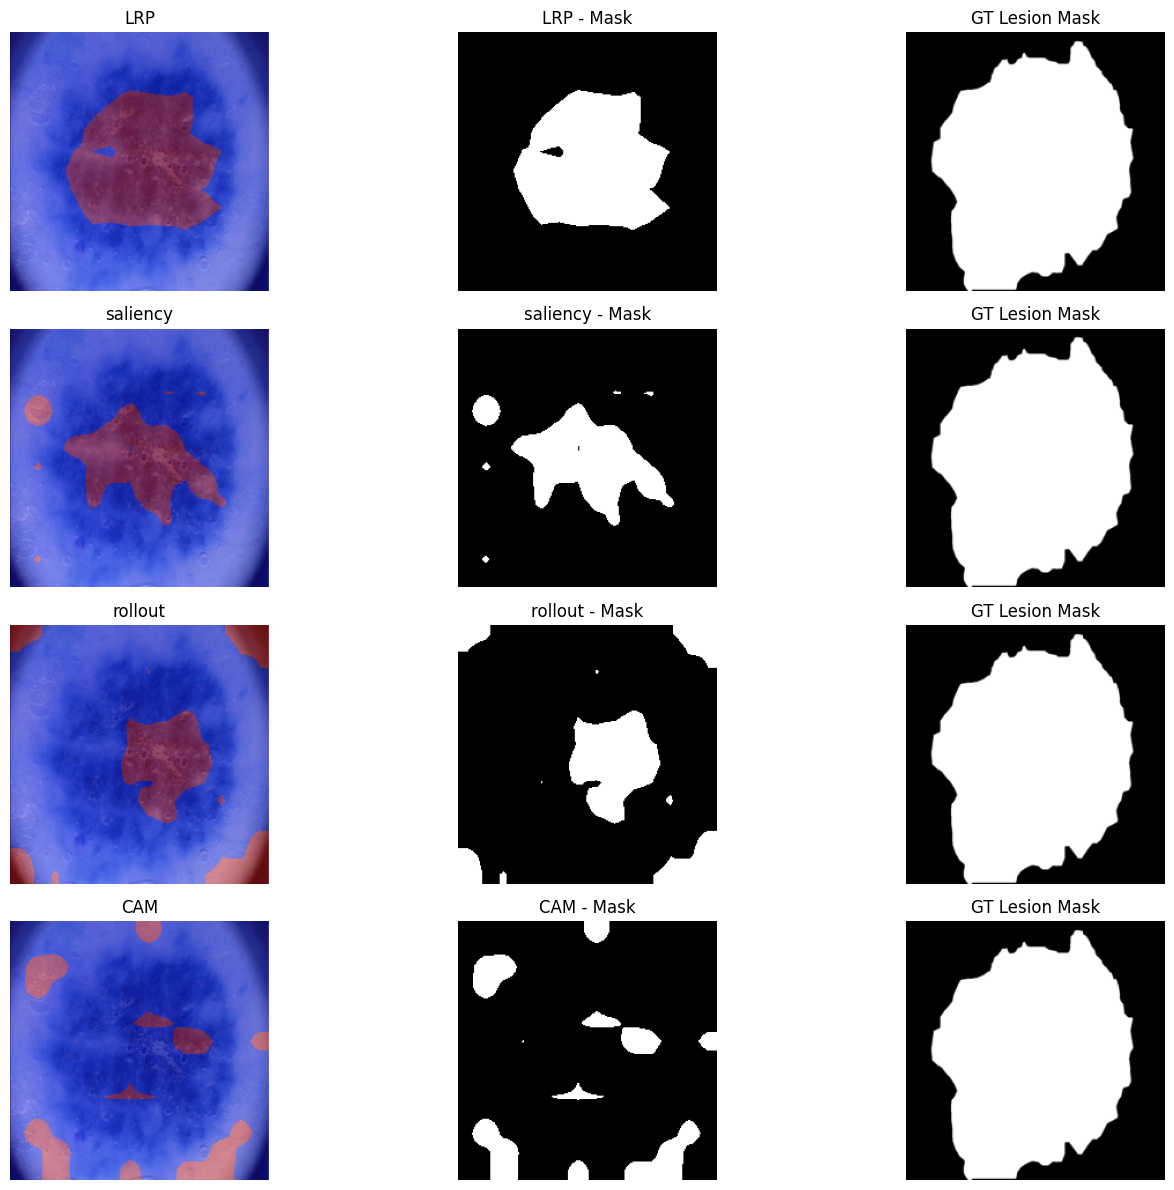

In [32]:
import os
from PIL import Image
import torch
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

folder2='./test'
os.makedirs(folder2, exist_ok=True)

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def generate_LRP(original_image, class_index):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    return transformer_attribution

def generate_saliency(original_image, class_index):
    original_image.requires_grad_()
    output = model_B(original_image.unsqueeze(0).cuda())
    loss = output[0, class_index] if class_index is not None else output.max()
    model_B.zero_grad()
    loss.backward()
    saliency = original_image.grad.data.abs().max(dim=0, keepdim=True)[0]
    saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0), size=(14, 14), mode='bilinear')
    return saliency

def generate_rollout(input_image, start_layer=3):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    return transformer_attribution

def generate_CAM(input_image, class_index):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    return transformer_attribution

def combine_and_visualize_attributions(input_image, method, use_thresholding=True):
    device = input_image.device
    attr = method(input_image).reshape(1, 1, 14, 14).to(device)

    combined_attr = torch.nn.functional.interpolate(attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, combined_attr

def print_top_classes(predictions):
    prob = torch.softmax(predictions, dim=1)
    top_prob, top_class = prob.topk(1, dim=1)
    return top_prob.item(), top_class.item()

# Function to visualize each method with different combine methods
def visualize_methods(input_image, use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }

    # Determine the predicted class index
    output = model_A(input_image.unsqueeze(0).cuda())
    class_index = output.argmax().item()
    top_prob, top_class = print_top_classes(output)

    results = []
    for method_name, method_func in methods.items():
          vis, mask = combine_and_visualize_attributions(input_image, lambda img: method_func(img, class_index), use_thresholding)
          results.append((f"{method_name}", vis, mask))

    return results

transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),        
        transforms.Normalize(mean=[0.5], std=[0.5]) 
    ])

def get_image_and_mask_paths(image_id: str) -> tuple:
    base_path = r'/kaggle/working/Transformer-Explainability/PH2Dataset/PH2 Dataset images'
    image_path = f"{base_path}/{image_id}/{image_id}_Dermoscopic_Image/{image_id}.bmp"
    mask_path = f"{base_path}/{image_id}/{image_id}_lesion/{image_id}_lesion.bmp"
    return image_path, mask_path

image_id = "IMD030"
image_path, mask_path = get_image_and_mask_paths(image_id)

image = Image.open(image_path).convert('RGB')
lesion_mask = Image.open(mask_path).convert('L')
im = transform(image).cuda()
lesion_mask = transforms.Resize((224, 224))(lesion_mask)
lesion_mask = np.array(lesion_mask)

results = visualize_methods(im, use_thresholding=True)

# Save the results
for name, result, mask in results:
    save_path = os.path.join(folder2, f"{image_id}_{name}.png")
    cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    mask_path = os.path.join(folder2, f"{name}_mask.png")
    cv2.imwrite(mask_path, mask * 255) 

# Display the results
fig, axes = plt.subplots(len(results), 3, figsize=(15, len(results)*3))
for ax_row, (name, result, mask) in zip(axes, results):
    ax_row[0].imshow(result)
    ax_row[0].set_title(name)
    ax_row[0].axis('off')

    ax_row[1].imshow(mask, cmap='gray')
    ax_row[1].set_title(f"{name} - Mask")
    ax_row[1].axis('off')

    ax_row[2].imshow(lesion_mask, cmap='gray')
    ax_row[2].set_title("GT Lesion Mask")
    ax_row[2].axis('off')

plt.tight_layout()
plt.show()

Metric Results

In [17]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

# Define the output folder
output_folder = "1way_folder"
os.makedirs(output_folder, exist_ok=True)

all_results_one_way = []

for idx, (image_data, lesion_data) in enumerate(zip(cleaned_images, cleaned_lesions)):
    image = Image.fromarray(image_data) 
    lesion_mask = Image.fromarray(lesion_data).convert('L') 

    # Apply transformations
    im = val_test_transform(image).cuda()
    lesion_mask = transforms.Resize((224, 224))(lesion_mask)

    # Convert lesion_mask to binary
    lesion_mask = np.array(lesion_mask)
    lesion_mask = (lesion_mask > 0).astype(np.uint8) 

    # Visualize all combinations of methods
    results = visualize_methods(im, use_thresholding=True)
    if results != []:
        for name, result, mask in results:
            # Compute evaluation metrics
            intersection = np.logical_and(lesion_mask, mask)
            union = np.logical_or(lesion_mask, mask)
            jaccard = np.sum(intersection) / np.sum(union)
            tp = np.sum(intersection)
            fp = np.sum(mask) - tp
            fn = np.sum(lesion_mask) - tp
            f1 = 2 * tp / (2 * tp + fp + fn)
            pixel_accuracy = np.sum(intersection) / np.sum(lesion_mask)
    
            all_results_one_way.append({
                "Image Index": idx,
                "Method": name,
                "Jaccard Index (IoU)": jaccard,
                "F1 Score": f1,
                "Pixel Accuracy": pixel_accuracy
            })

# Show an example result
if all_results_one_way:
    print("Example result:")
    print(all_results_one_way[0])

<ipython-input-16-1a2de2fa8acb>:52: RuntimeWarning: invalid value encountered in cast
  combined_attr = combined_attr.astype(np.uint8)


Example result:
{'Image Index': 0, 'Method': 'LRP', 'Jaccard Index (IoU)': 0.4288618959598627, 'F1 Score': 0.600284600173717, 'Pixel Accuracy': 0.4370206926243845}


In [18]:
def save_and_display_results(file_name_for_saving, results):
  results_df = pd.DataFrame(results)
  csv_path = file_name_for_saving
  results_df.to_csv(csv_path, index=False)
  print(f"Results saved to {csv_path}")


  print("Statistics by Method and Combine Method:")
  stats = results_df.groupby("Method")[["Jaccard Index (IoU)", "F1 Score", "Pixel Accuracy"]].mean()
  print(stats)

In [19]:
save_and_display_results("metrics_results_1WAY.csv", all_results_one_way)

Results saved to metrics_results_1WAY.csv
Statistics by Method and Combine Method:
          Jaccard Index (IoU)  F1 Score  Pixel Accuracy
Method                                                 
CAM                  0.348260  0.451526        0.399772
LRP                  0.522031  0.665417        0.532492
rollout              0.536595  0.674317        0.676066
saliency             0.390876  0.526190        0.472190


In [22]:
import numpy as np
import torch
import cv2
from sklearn.metrics import auc  # For Area Under Curve

def deletion_metric(model, image, attribution_map, class_index=None, steps=100):
    """
    Computes the Deletion Metric for a given attribution map.

    Parameters:
    - model: Trained model used for classification.
    - image: Input image tensor (C, H, W).
    - attribution_map: The heatmap from CAM or LRP, normalized [0, 1].
    - class_index: Class index to track model confidence for (optional).
    - steps: Number of steps for iterative deletion.

    Returns:
    - auc_score: Area under the confidence curve (lower = better attribution).
    - confidence_drop: List of model confidences after each deletion step.
    """
    model.eval()

    # Flatten the attribution map and sort pixel indices by importance (descending order)
    importance_order = np.argsort(-attribution_map.flatten())

    # Create a copy of the image for deletion process
    image_np = image.permute(1, 2, 0).detach().cpu().numpy()  # Convert to (H, W, C)
    modified_image = image_np.copy()

    # Initial model confidence before deletion
    with torch.no_grad():
        output = model(image.unsqueeze(0).cuda())
        if class_index is None:
            class_index = output.argmax().item()
        initial_confidence = torch.softmax(output, dim=1)[0, class_index].item()

    confidence_drop = [initial_confidence]

    # Deletion process: remove pixels in steps
    total_pixels = image_np.shape[0] * image_np.shape[1]
    pixels_per_step = total_pixels // steps

    for step in range(1, steps + 1):
        # Mask out the most important pixels
        pixels_to_mask = importance_order[(step - 1) * pixels_per_step: step * pixels_per_step]

        # Set those pixels to zero (blackout)
        for idx in pixels_to_mask:
            h, w = divmod(idx, image_np.shape[1])  # Convert 1D index to 2D coordinates
            modified_image[h, w, :] = 0  # Black out across all channels

        # Convert modified image back to tensor
        modified_image_tensor = torch.from_numpy(modified_image).permute(2, 0, 1).float().cuda()

        # Recalculate model confidence
        with torch.no_grad():
            output = model(modified_image_tensor.unsqueeze(0))
            confidence = torch.softmax(output, dim=1)[0, class_index].item()

        confidence_drop.append(confidence)

    # Calculate Area Under the Confidence Curve (AUC)
    x_axis = np.linspace(0, 1, len(confidence_drop))  # Percentage of pixels deleted
    auc_score = auc(x_axis, confidence_drop)

    return auc_score, confidence_drop


In [15]:
from tqdm import tqdm
all_expl_results_one_way = []
for idx, (image_data, lesion_data) in tqdm(enumerate(zip(cleaned_images, cleaned_lesions))):

    image = Image.fromarray(image_data).convert('RGB')
    im = val_test_transform(image).cuda()
    
    # Visualize all combinations of methods
    results = visualize_methods(im, use_thresholding=True)
    
    if results != []:
        i+=1
        for name, result, mask in results:
            mask = (mask - mask.min()) / (mask.max() - mask.min())
            mask = mask.flatten()
            auccc, _ = deletion_metric(model_A, im, mask)
            all_expl_results_one_way.append({
                "Image Index": idx,
                "Method": name,
                "Deletion Accuracy": auccc
            })

128it [15:36,  7.60s/it]<ipython-input-13-5a21a4787432>:52: RuntimeWarning: invalid value encountered in cast
  combined_attr = combined_attr.astype(np.uint8)
<ipython-input-15-2ba554022847>:24: RuntimeWarning: invalid value encountered in divide
  mask = (mask - mask.min()) / (mask.max() - mask.min())
200it [24:43,  7.42s/it]

200


In [16]:
def save_and_display_results1(file_name_for_saving, results):
  results_df = pd.DataFrame(results)
  csv_path = file_name_for_saving
  results_df.to_csv(csv_path, index=False)
  print(f"Results saved to {csv_path}")


  print("Statistics by Method and Combine Method:")
  stats = results_df.groupby("Method")[["Deletion Accuracy"]].mean()
  print(stats)

In [17]:
save_and_display_results1("metrics_expl_results_1WAY.csv", all_expl_results_one_way)

Results saved to metrics_expl_results_1WAY.csv
Statistics by Method and Combine Method:
          Deletion Accuracy
Method                     
CAM                0.502829
LRP                0.451485
rollout            0.461441
saliency           0.490451


# 2WAY

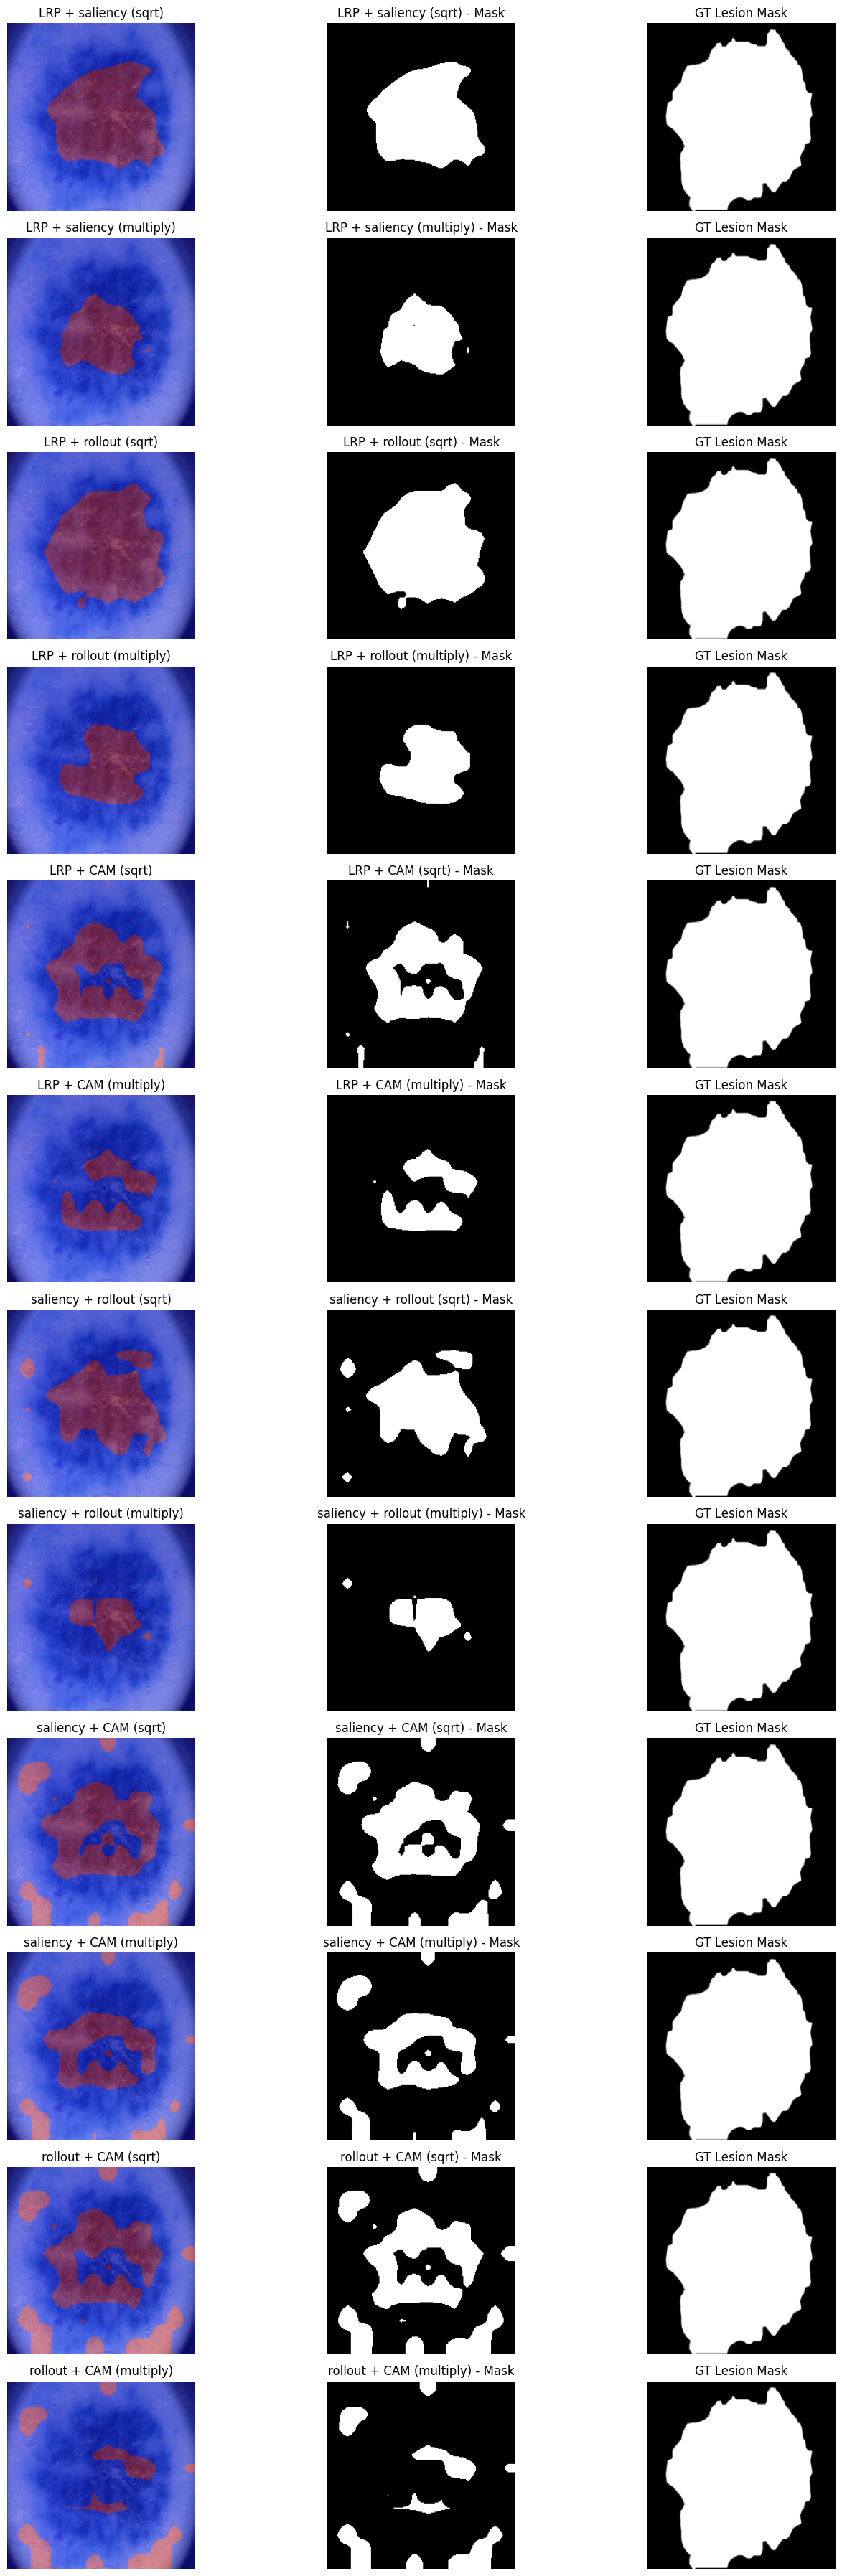

In [31]:
from itertools import combinations

# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, method1, method2, combine_method='sqrt', use_thresholding=True):
    device = input_image.device
    attr1 = method1(input_image).reshape(1, 1, 14, 14).to(device)
    attr2 = method2(input_image).reshape(1, 1, 14, 14).to(device)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attr1 * attr2)
    elif combine_method == 'multiply':
        combined_attr = attr1 * attr2

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, combined_attr

def visualize_combined_methods(input_image, method1_name, method2_name, class_index, combine_method='sqrt', use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }
    method1 = methods[method1_name]
    method2 = methods[method2_name]

    return combine_and_visualize_attributions(input_image, lambda img: method1(img, class_index), lambda img: method2(img, class_index), combine_method, use_thresholding)

# Function to visualize all 2-way combinations
def visualize_all_combinations(input_image, lesion_mask, combine_methods=['sqrt', 'multiply'], use_thresholding=True):
    methods = ['LRP', 'saliency', 'rollout', 'CAM']
    combinations_list = list(combinations(methods, 2))

    # Determine the predicted class index
    output = model_A(input_image.unsqueeze(0).cuda())
    class_index = output.argmax().item()

    results = []
    for combo in combinations_list:
        for combine_method in combine_methods:
            vis, mask = visualize_combined_methods(input_image, combo[0], combo[1], class_index, combine_method, use_thresholding)
            results.append((f"{' + '.join(combo)} ({combine_method})", vis, mask))

    return results

transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),        
        transforms.Normalize(mean=[0.5], std=[0.5])  
    ])

def get_image_and_mask_paths(image_id: str) -> tuple:
    base_path = r'/kaggle/working/Transformer-Explainability/PH2Dataset/PH2 Dataset images'
    image_path = f"{base_path}/{image_id}/{image_id}_Dermoscopic_Image/{image_id}.bmp"
    mask_path = f"{base_path}/{image_id}/{image_id}_lesion/{image_id}_lesion.bmp"
    return image_path, mask_path

image_id = "IMD030"
image_path, mask_path = get_image_and_mask_paths(image_id)

image = Image.open(image_path)
lesion_mask = Image.open(mask_path).convert('L')

im = transform(image).cuda()
lesion_mask = transforms.Resize((224, 224))(lesion_mask)
lesion_mask = np.array(lesion_mask)

# Visualize all combinations
results = visualize_all_combinations(im, lesion_mask, combine_methods=['sqrt', 'multiply'], use_thresholding=True)

# Save the results
for name, result, mask in results:
    save_path = os.path.join(folder2, f"{image_id}_{name}.png")
    cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    mask_path = os.path.join(folder2, f"{name}_mask.png")
    cv2.imwrite(mask_path, mask * 255)  # Save binary mask

# Display the results
fig, axes = plt.subplots(len(results), 3, figsize=(15, len(results)*3))
for ax_row, (name, result, mask) in zip(axes, results):
    ax_row[0].imshow(result)
    ax_row[0].set_title(name)
    ax_row[0].axis('off')

    ax_row[1].imshow(mask, cmap='gray')
    ax_row[1].set_title(f"{name} - Mask")
    ax_row[1].axis('off')

    ax_row[2].imshow(lesion_mask, cmap='gray')
    ax_row[2].set_title("GT Lesion Mask")
    ax_row[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm

all_results_two_way = []

for idx, (image_data, lesion_data) in enumerate(tqdm(zip(cleaned_images, cleaned_lesions), total=len(cleaned_images))):
    image = Image.fromarray(image_data)  
    lesion_mask = Image.fromarray(lesion_data).convert('L') 

    # Apply transformations
    im = val_test_transform(image).cuda()
    lesion_mask = transforms.Resize((224, 224))(lesion_mask)

    # Convert lesion_mask to binary
    lesion_mask = np.array(lesion_mask)
    lesion_mask = (lesion_mask > 0).astype(np.uint8) 

    # Visualize all combinations of methods
    results = visualize_all_combinations(im, lesion_mask, use_thresholding=True)
    if results != []:
        for name, result, mask in results:
            intersection = np.logical_and(lesion_mask, mask)
            union = np.logical_or(lesion_mask, mask)
            jaccard = np.sum(intersection) / np.sum(union)
            tp = np.sum(intersection)
            fp = np.sum(mask) - tp
            fn = np.sum(lesion_mask) - tp
            f1 = 2 * tp / (2 * tp + fp + fn)
            pixel_accuracy = np.sum(intersection) / np.sum(lesion_mask)
    
            all_results_two_way.append({
                "Image Index": idx,
                "Method": name,
                "Jaccard Index (IoU)": jaccard,
                "F1 Score": f1,
                "Pixel Accuracy": pixel_accuracy
            })

In [33]:
def save_and_display_results_2way(file_name_for_saving, results):
  results_df = pd.DataFrame(results)
  csv_path = file_name_for_saving
  results_df.to_csv(csv_path, index=False)
  print(f"Results saved to {csv_path}")


  print("Statistics by Method and Combine Method:")
  stats = results_df.groupby("Method")[["Jaccard Index (IoU)", "F1 Score", "Pixel Accuracy"]].mean()
  print(stats)

In [35]:
save_and_display_results_2way("metrics_results_2WAY.csv", all_results_two_way)

Results saved to metrics_results_2WAY.csv
Statistics by Method and Combine Method:
                               Jaccard Index (IoU)  F1 Score  Pixel Accuracy
Method                                                                      
LRP + CAM (multiply)                      0.295688  0.417338        0.299243
LRP + CAM (sqrt)                          0.440980  0.566340        0.455038
LRP + rollout (multiply)                  0.491258  0.631668        0.502266
LRP + rollout (sqrt)                      0.644868  0.766611        0.671320
LRP + saliency (multiply)                 0.357456  0.497087        0.365374
LRP + saliency (sqrt)                     0.581824  0.716170        0.607364
rollout + CAM (multiply)                  0.361785  0.472749        0.394931
rollout + CAM (sqrt)                      0.463214  0.573967        0.556903
saliency + CAM (multiply)                 0.300892  0.417653        0.316892
saliency + CAM (sqrt)                     0.460995  0.579288        0.

In [23]:
from tqdm import tqdm
all_expl_results_one_way = []
for idx, (image_data, lesion_data) in tqdm(enumerate(zip(cleaned_images, cleaned_lesions))):
    image = Image.fromarray(image_data).convert('RGB')
    im = val_test_transform(image).cuda()

    lesion_mask = Image.fromarray(lesion_data).convert('L')
    
    # Visualize all combinations of methods
    results = visualize_all_combinations(im, lesion_mask, combine_methods=['sqrt', 'multiply'], use_thresholding=False)

    for name, result, mask in results:
        mask = (mask - mask.min()) / (mask.max() - mask.min())
        mask = mask.flatten()
        auccc, _ = deletion_metric(model_A, im, mask)
        all_expl_results_one_way.append({
            "Image Index": idx,
            "Method": name,
            "Deletion Accuracy": auccc
        })

128it [50:11, 23.80s/it]<ipython-input-12-41d1d44fb647>:8: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
200it [1:18:42, 23.61s/it]


In [24]:
def save_and_display_results1(file_name_for_saving, results):
  results_df = pd.DataFrame(results)
  csv_path = file_name_for_saving
  results_df.to_csv(csv_path, index=False)
  print(f"Results saved to {csv_path}")


  print("Statistics by Method and Combine Method:")
  stats = results_df.groupby("Method")[["Deletion Accuracy"]].mean()
  print(stats)

save_and_display_results1("metrics_expl_results_2WAY.csv", all_expl_results_one_way)

Results saved to metrics_expl_results_2WAY.csv
Statistics by Method and Combine Method:
                               Deletion Accuracy
Method                                          
LRP + CAM (multiply)                    0.368227
LRP + CAM (sqrt)                        0.376977
LRP + rollout (multiply)                0.318572
LRP + rollout (sqrt)                    0.321284
LRP + saliency (multiply)               0.317298
LRP + saliency (sqrt)                   0.321118
rollout + CAM (multiply)                0.394133
rollout + CAM (sqrt)                    0.397295
saliency + CAM (multiply)               0.382335
saliency + CAM (sqrt)                   0.388456
saliency + rollout (multiply)           0.345348
saliency + rollout (sqrt)               0.349200


# 3way

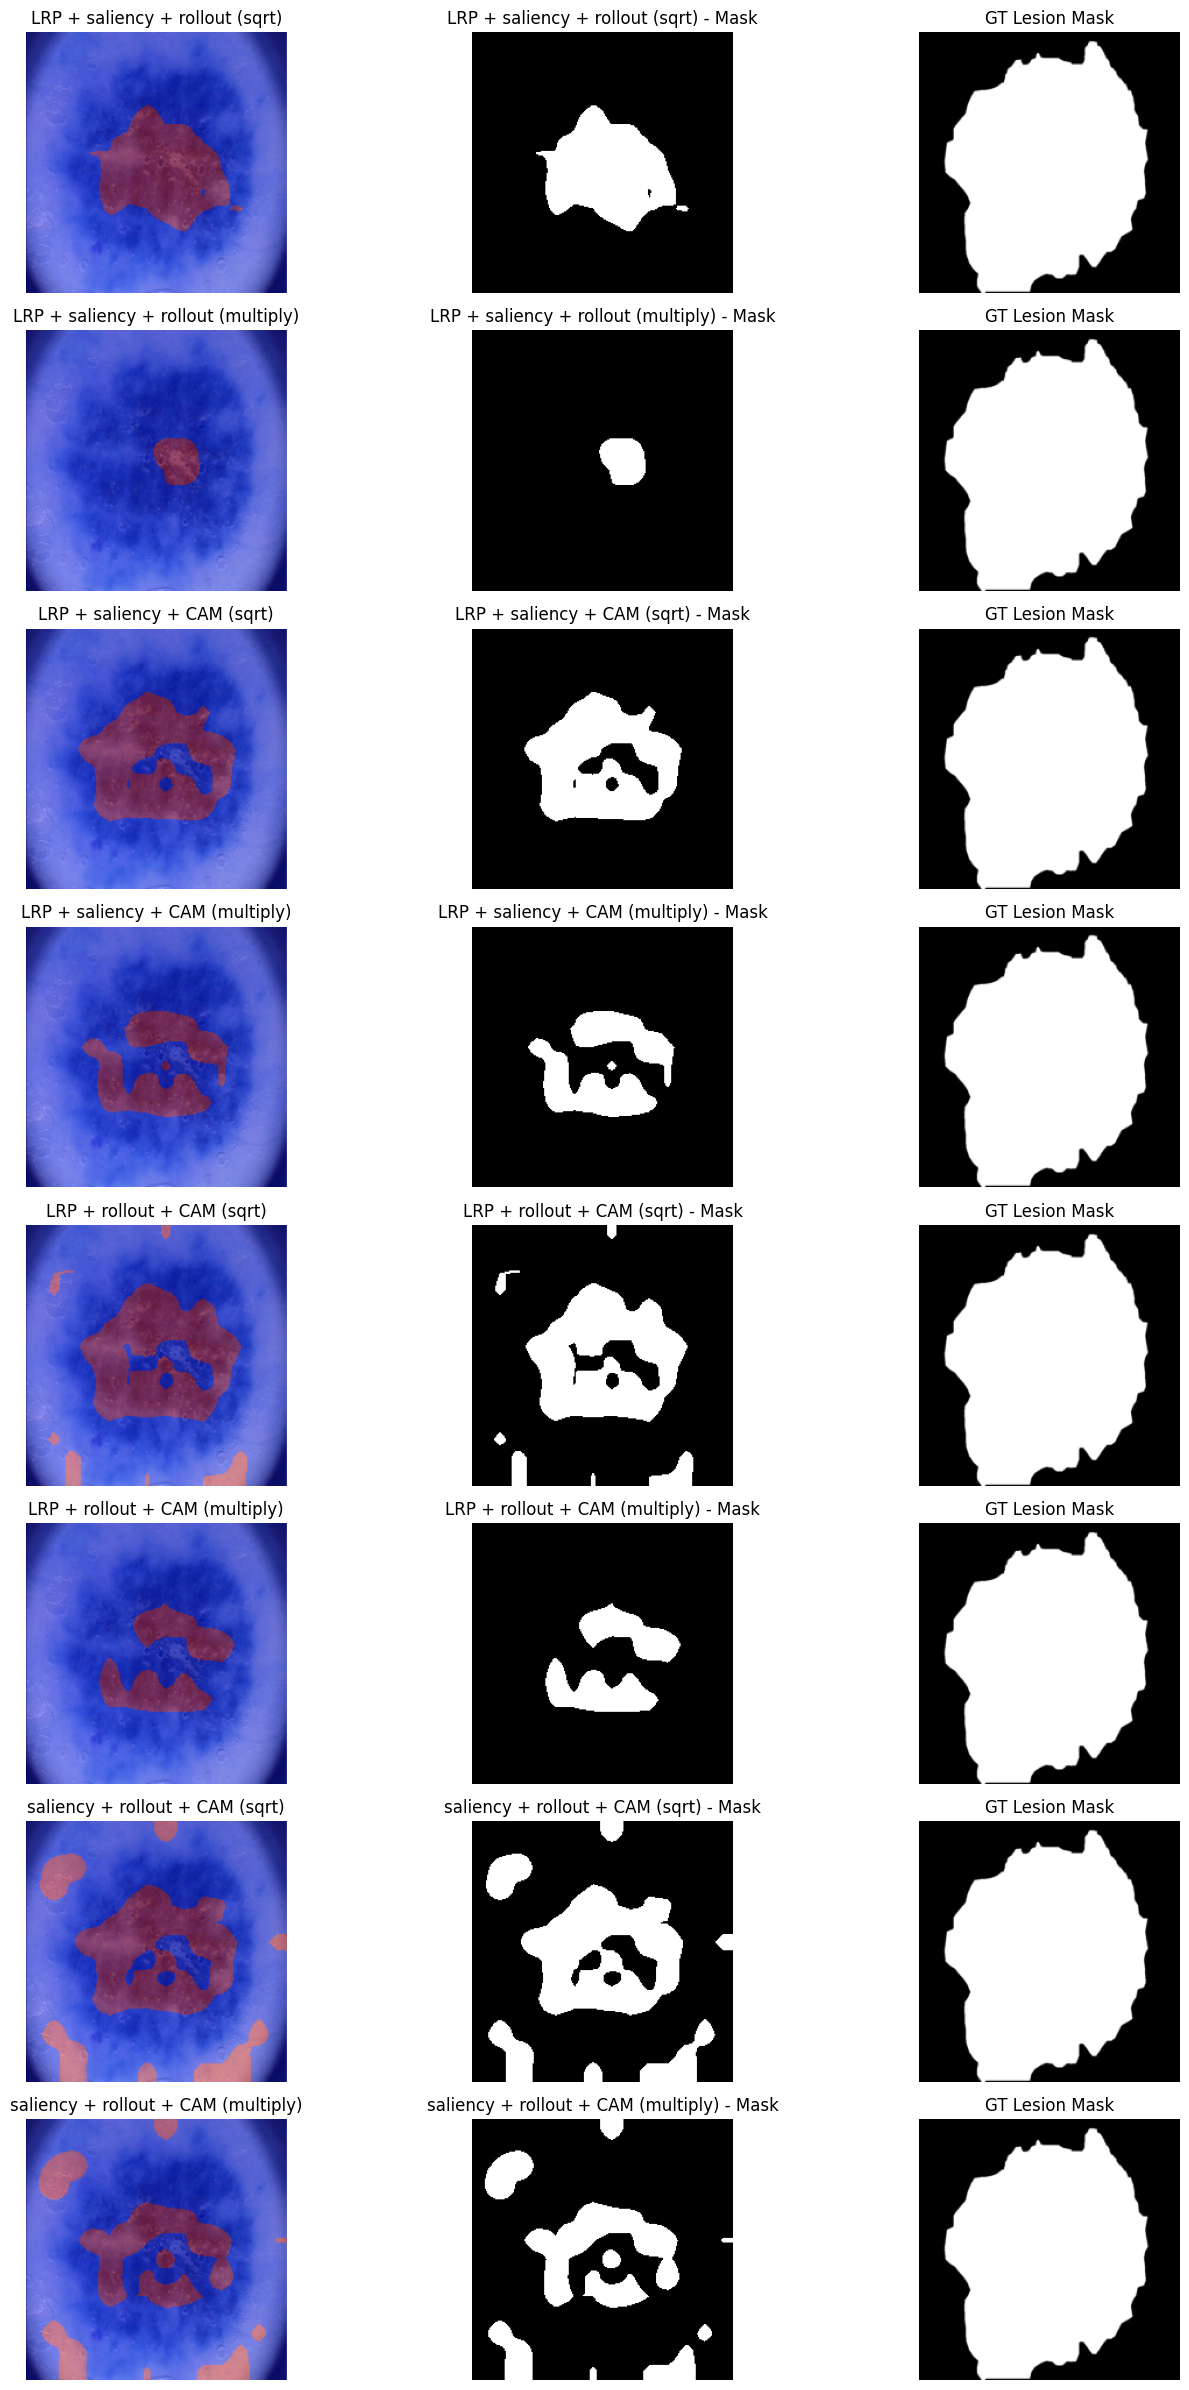

In [27]:
from itertools import combinations
def combine_and_visualize_attributions(input_image, methods, combine_method='sqrt', use_thresholding=True):
    device = input_image.device
    attributions = []
    for method in methods:
        if method.__name__ in ['generate_saliency', 'generate_CAM', 'generate_LRP']:
            attr = method(input_image, class_index=1).reshape(1, 1, 14, 14).to(device) 
        else:
            attr = method(input_image).reshape(1, 1, 14, 14).to(device)
        attributions.append(attr)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attributions[0] * attributions[1] * attributions[2])
    elif combine_method == 'multiply':
        combined_attr = attributions[0] * attributions[1] * attributions[2]

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, combined_attr

def visualize_combined_methods(input_image, method_names, class_index, combine_method='sqrt', use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }
    selected_methods = [methods[name] for name in method_names]

    return combine_and_visualize_attributions(input_image, selected_methods, combine_method, use_thresholding)

# Function to visualize all 3-way combinations
def visualize_all_combinations(input_image, combine_methods=['sqrt', 'multiply'], use_thresholding=True):
    methods = ['LRP', 'saliency', 'rollout', 'CAM']
    combinations_list = list(combinations(methods, 3))

    # Determine the predicted class index
    output = model_A(input_image.unsqueeze(0).cuda())
    class_index = output.argmax().item()

    results = []
    for combo in combinations_list:
        for combine_method in combine_methods:
            vis, mask = visualize_combined_methods(input_image, combo, class_index, combine_method, use_thresholding)
            results.append((f"{' + '.join(combo)} ({combine_method})", vis, mask))

    return results


transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),       
        transforms.Normalize(mean=[0.5], std=[0.5]) 
    ])

def get_image_and_mask_paths(image_id: str) -> tuple:
    base_path = r'/kaggle/working/Transformer-Explainability/PH2Dataset/PH2 Dataset images'
    image_path = f"{base_path}/{image_id}/{image_id}_Dermoscopic_Image/{image_id}.bmp"
    mask_path = f"{base_path}/{image_id}/{image_id}_lesion/{image_id}_lesion.bmp"
    return image_path, mask_path

image_id = "IMD030"
image_path, mask_path = get_image_and_mask_paths(image_id)

image = Image.open(image_path)
lesion_mask = Image.open(mask_path).convert('L')

im = transform(image).cuda()
lesion_mask = transforms.Resize((224, 224))(lesion_mask)
lesion_mask = np.array(lesion_mask)

# Visualize all combinations
results = visualize_all_combinations(im, combine_methods=['sqrt', 'multiply'], use_thresholding=True)

# Save the results
for name, result, mask in results:
    save_path = os.path.join(folder2, f"{image_id}_{name}.png")
    cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    mask_path = os.path.join(folder2, f"{name}_mask.png")
    cv2.imwrite(mask_path, mask * 255)  # Save binary mask

# Display the results
fig, axes = plt.subplots(len(results), 3, figsize=(15, len(results)*3))
for ax_row, (name, result, mask) in zip(axes, results):
    ax_row[0].imshow(result)
    ax_row[0].set_title(name)
    ax_row[0].axis('off')

    ax_row[1].imshow(mask, cmap='gray')
    ax_row[1].set_title(f"{name} - Mask")
    ax_row[1].axis('off')

    ax_row[2].imshow(lesion_mask, cmap='gray')
    ax_row[2].set_title("GT Lesion Mask")
    ax_row[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm

all_results_three_way = []

for idx, (image_data, lesion_data) in enumerate(tqdm(zip(cleaned_images, cleaned_lesions), total=len(cleaned_images))):
    image = Image.fromarray(image_data)  
    lesion_mask = Image.fromarray(lesion_data).convert('L') 

    # Apply transformations
    im = val_test_transform(image).cuda()
    lesion_mask = transforms.Resize((224, 224))(lesion_mask)

    # Convert lesion_mask to binary
    lesion_mask = np.array(lesion_mask)
    lesion_mask = (lesion_mask > 0).astype(np.uint8) 

    # Visualize all combinations of methods
    results = visualize_all_combinations(im, use_thresholding=True)
    if results != []:
        for name, result, mask in results:
            # Compute evaluation metrics
            intersection = np.logical_and(lesion_mask, mask)
            union = np.logical_or(lesion_mask, mask)
            jaccard = np.sum(intersection) / np.sum(union)
            tp = np.sum(intersection)
            fp = np.sum(mask) - tp
            fn = np.sum(lesion_mask) - tp
            f1 = 2 * tp / (2 * tp + fp + fn)
            pixel_accuracy = np.sum(intersection) / np.sum(lesion_mask)
    
            all_results_three_way.append({
                "Image Index": idx,
                "Method": name,
                "Jaccard Index (IoU)": jaccard,
                "F1 Score": f1,
                "Pixel Accuracy": pixel_accuracy
            })

In [21]:
def save_and_display_results_2way(file_name_for_saving, results):
  results_df = pd.DataFrame(results)
  csv_path = file_name_for_saving
  results_df.to_csv(csv_path, index=False)
  print(f"Results saved to {csv_path}")


  print("Statistics by Method and Combine Method:")
  stats = results_df.groupby("Method")[["Jaccard Index (IoU)", "F1 Score", "Pixel Accuracy"]].mean()
  print(stats)
save_and_display_results_2way("metrics_results_3WAY.csv", all_results_three_way)

Results saved to metrics_results_3WAY.csv
Statistics by Method and Combine Method:
                                     Jaccard Index (IoU)  F1 Score  \
Method                                                               
LRP + rollout + CAM (multiply)                  0.299559  0.421093   
LRP + rollout + CAM (sqrt)                      0.437154  0.560382   
LRP + saliency + CAM (multiply)                 0.225308  0.338865   
LRP + saliency + CAM (sqrt)                     0.393165  0.520859   
LRP + saliency + rollout (multiply)             0.303232  0.428671   
LRP + saliency + rollout (sqrt)                 0.568092  0.697542   
saliency + rollout + CAM (multiply)             0.235220  0.344499   
saliency + rollout + CAM (sqrt)                 0.421487  0.541025   

                                     Pixel Accuracy  
Method                                               
LRP + rollout + CAM (multiply)             0.302576  
LRP + rollout + CAM (sqrt)                 0.449095  


In [24]:
from tqdm import tqdm
all_expl_results_three_way = []
for idx, (image_data, lesion_data) in tqdm(enumerate(zip(cleaned_images, cleaned_lesions))):
    image = Image.fromarray(image_data).convert('RGB') 
    im = val_test_transform(image).cuda()

    lesion_mask = Image.fromarray(lesion_data).convert('L')
    results = visualize_all_combinations(im, combine_methods=['sqrt', 'multiply'], use_thresholding=False)

    for name, result, mask in results:
        mask = (mask - mask.min()) / (mask.max() - mask.min())
        mask = mask.flatten()
        auccc, _ = deletion_metric(model_A, im, mask)
        all_expl_results_three_way.append({
            "Image Index": idx,
            "Method": name,
            "Deletion Accuracy": auccc
        })
def save_and_display_results1(file_name_for_saving, results):
  results_df = pd.DataFrame(results)
  csv_path = file_name_for_saving
  results_df.to_csv(csv_path, index=False)
  print(f"Results saved to {csv_path}")


  print("Statistics by Method and Combine Method:")
  stats = results_df.groupby("Method")[["Deletion Accuracy"]].mean()
  print(stats)

save_and_display_results1("metrics_expl_results_3WAY.csv", all_expl_results_three_way)

200it [47:49, 14.35s/it]

Results saved to metrics_expl_results_3WAY.csv
Statistics by Method and Combine Method:
                                     Deletion Accuracy
Method                                                
LRP + rollout + CAM (multiply)                0.360334
LRP + rollout + CAM (sqrt)                    0.368325
LRP + saliency + CAM (multiply)               0.354667
LRP + saliency + CAM (sqrt)                   0.363504
LRP + saliency + rollout (multiply)           0.323471
LRP + saliency + rollout (sqrt)               0.327190
saliency + rollout + CAM (multiply)           0.364063
saliency + rollout + CAM (sqrt)               0.370388
